In [1]:
# 전처리 관련 모듈

import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import missingno as msno

In [2]:
dataset = pd.read_csv("sensor.csv").iloc[:, 2:]
dataset.fillna(0.0, inplace=True)
dataset.head(5)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [3]:
dataset.loc[dataset["machine_status"]=='BROKEN', 'class'] = '0' #이상
dataset.loc[dataset["machine_status"]=='RECOVERING', 'class'] = '0' #이상
dataset.loc[dataset["machine_status"]=='NORMAL', 'class'] = '1' #정상

In [4]:
del dataset['machine_status']

In [5]:
normal_dataset = dataset['class'].isin(['1'])
normal_dataset = dataset.loc[normal_dataset]
normal_dataset.shape

(205836, 53)

In [6]:
abnormal_dataset = dataset['class'].isin(['0'])
abnormal_dataset = dataset.loc[abnormal_dataset]
abnormal_dataset.shape

(14484, 53)

In [7]:
chosen_idx = np.random.choice(205836, size =16000)
test_dataset_normal = normal_dataset[normal_dataset.index.isin(chosen_idx)]

test_dataset = pd.concat([test_dataset_normal, abnormal_dataset.iloc[:test_dataset_normal.shape[0], :]])
test_dataset_normal.shape, test_dataset.shape

((14322, 53), (28644, 53))

In [8]:
train_dataset = normal_dataset[~normal_dataset.index.isin(chosen_idx)]
train_dataset.shape

(191514, 53)

In [9]:
train_y = train_dataset['class']
test_y = test_dataset['class']

del train_dataset['class']
del test_dataset['class']

train_y.shape, test_y.shape

((191514,), (28644,))

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = MinMaxScaler()
X_scaled_train  = scaler.fit_transform(train_dataset)
X_scaled_test  = scaler.fit_transform(test_dataset)
X_scaled_train.shape, X_scaled_test.shape

((191514, 52), (28644, 52))

In [11]:
import math 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

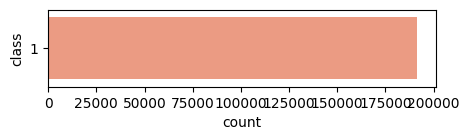

In [12]:
plt.figure(figsize=(5,1))
fig = sns.countplot(y=train_y, data=train_y, color='#fc9272')
plt.show()

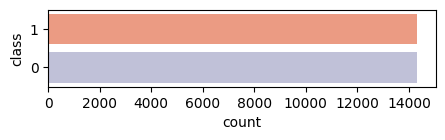

In [13]:
plt.figure(figsize=(5,1))
fig = sns.countplot(y=test_y, data=test_y, palette=["#fc9272", "#bcbddc"])
plt.show()

In [14]:
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

### knn

In [15]:
from pyod.models.knn import KNN
knn = KNN(contamination=0.1, n_neighbors=3, radius=2.0)
knn.fit(X_scaled_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=3, p=2,
  radius=2.0)

In [16]:
anomaly_score_knn_train = knn.decision_function(X_scaled_train)
anomaly_score_knn_sorted = sorted(anomaly_score_knn_train)

In [17]:
knn_test_pred = knn.predict(X_scaled_test) 

In [18]:
anomaly_score_knn_test = knn.decision_function(X_scaled_test)
anomaly_score_knn_test.shape

(28644,)

In [19]:
error = np.array(anomaly_score_knn_sorted)     
error = error.reshape(-1,1)

error_test=np.array(anomaly_score_knn_test)
error_test = error_test.reshape(-1,1)

In [20]:
thresh_knn = np.percentile(error, 95)

In [21]:
# classifier
df_test = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > thresh_knn:
            df_test.append('1')
        else:
            df_test.append('0')

In [22]:
novelty_classifier(error_test)

In [23]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset

    df_pred_test = pd.DataFrame(X_test, columns=['Pred'])
    x_pred = df_pred_test['Pred'] 
    
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Normal [0]', 'Abnormal [1]'], 
                yticklabels=['Normal [0]', 'Abnormal [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(X_test, y_true))
    
    model_score = score(X_test, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67     28644

    accuracy                           0.50     28644
   macro avg       0.50      0.25      0.33     28644
weighted avg       1.00      0.50      0.67     28644

f1_score: 33.33%


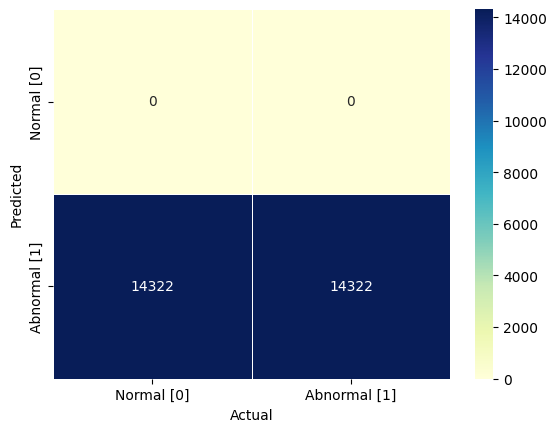

In [24]:
map_labels = True 
model_score = measure_performance(knn, df_test, test_y, map_labels)
performance_df = pd.DataFrame().append({'model_name':knn, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

In [25]:
#CBLOF  Cluster-based Local Outlier Factor

In [26]:
from pyod.models.cblof import CBLOF
CBLOF = CBLOF(contamination=0.1, check_estimator=False, random_state=1)
CBLOF.fit(X_scaled_train)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.1, n_clusters=8, n_jobs=None, random_state=1,
   use_weights=False)

In [27]:
anomaly_score_CBLOF_train = CBLOF.decision_function(X_scaled_train)
anomaly_score_CBLOF_train

array([0.32252411, 0.32252411, 0.30247061, ..., 0.28749495, 0.29497238,
       0.29452071])

In [28]:
anomaly_score_CBLOF_sorted = sorted(anomaly_score_CBLOF_train)

In [29]:
CBLOF_test_pred = CBLOF.predict(X_scaled_test) 

In [30]:
anomaly_score_CBLOF_test = CBLOF.decision_function(X_scaled_test)
anomaly_score_CBLOF_test.shape

(28644,)

In [31]:
error = np.array(anomaly_score_CBLOF_sorted)     
error = error.reshape(-1,1)

error_test=np.array(anomaly_score_CBLOF_test)
error_test = error_test.reshape(-1,1)

In [32]:
thresh_CBLOF = np.percentile(error, 50)

In [33]:
# classifier
df_test = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > thresh_CBLOF:
            df_test.append('1')
        else:
            df_test.append('0')

In [34]:
novelty_classifier(error_test)

In [35]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset

    df_pred_test = pd.DataFrame(X_test, columns=['Pred'])
    x_pred = df_pred_test['Pred'] 
    
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Normal [0]', 'Abnormal [1]'], 
                yticklabels=['Normal [0]', 'Abnormal [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(X_test, y_true))
    
    model_score = score(X_test, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67     28644

    accuracy                           0.50     28644
   macro avg       0.50      0.25      0.33     28644
weighted avg       1.00      0.50      0.67     28644

f1_score: 33.33%


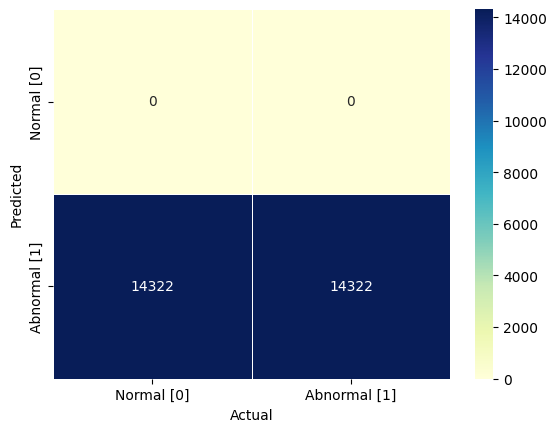

In [36]:
map_labels = True 
model_score = measure_performance(CBLOF, df_test, test_y, map_labels)
performance_df = pd.DataFrame().append({'model_name':CBLOF, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

In [37]:
from pyod.models.hbos import HBOS
HBOS = HBOS(contamination=0.1)
HBOS.fit(X_scaled_train)

HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5)

In [38]:
anomaly_score_HBOS_train = CBLOF.decision_function(X_scaled_train)
anomaly_score_HBOS_train

array([0.32252411, 0.32252411, 0.30247061, ..., 0.28749495, 0.29497238,
       0.29452071])

In [39]:
anomaly_score_HBOS_sorted = sorted(anomaly_score_HBOS_train)

In [40]:
HBOS_test_pred = HBOS.predict(X_scaled_test) 

In [41]:
anomaly_score_HBOS_test = HBOS.decision_function(X_scaled_test)
anomaly_score_HBOS_test.shape

(28644,)

In [42]:
error = np.array(anomaly_score_HBOS_sorted)     
error = error.reshape(-1,1)

error_test=np.array(anomaly_score_HBOS_test)
error_test = error_test.reshape(-1,1)

In [43]:
thresh_HBOS = np.percentile(error, 95)

In [44]:
# classifier
df_test = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > thresh_HBOS:
            df_test.append('1')
        else:
            df_test.append('0')

In [45]:
novelty_classifier(error_test)

In [46]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset

    df_pred_test = pd.DataFrame(X_test, columns=['Pred'])
    x_pred = df_pred_test['Pred'] 
    
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Normal [0]', 'Abnormal [1]'], 
                yticklabels=['Normal [0]', 'Abnormal [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(X_test, y_true))
    
    model_score = score(X_test, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

              precision    recall  f1-score   support

           0       0.86      0.47      0.61     26449
           1       0.02      0.12      0.03      2195

    accuracy                           0.44     28644
   macro avg       0.44      0.29      0.32     28644
weighted avg       0.80      0.44      0.56     28644

f1_score: 31.96%


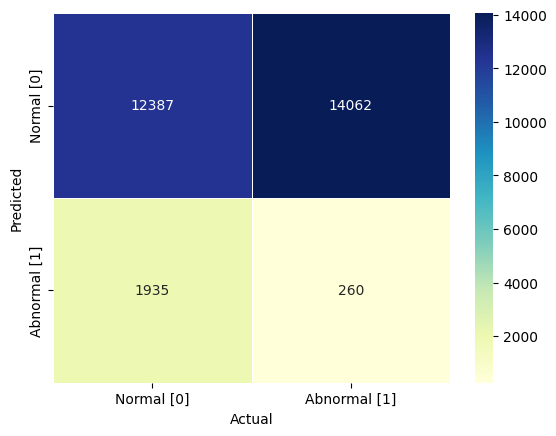

In [47]:
map_labels = True 
model_score = measure_performance(HBOS, df_test, test_y, map_labels)
performance_df = pd.DataFrame().append({'model_name':HBOS, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

In [48]:
from pyod.models.mcd import MCD
MCD = MCD(contamination=0.001, random_state=5)
MCD.fit(X_scaled_train)

MCD(assume_centered=False, contamination=0.001, random_state=5,
  store_precision=True, support_fraction=None)

In [49]:
anomaly_score_MCD_train = MCD.decision_function(X_scaled_train)
anomaly_score_MCD_train

array([ 77.67042902,  77.67042902,  73.26923426, ..., 169.88014347,
       157.93151366, 151.55939601])

In [50]:
anomaly_score_MCD_sorted = sorted(anomaly_score_MCD_train)

In [51]:
MCD_test_pred = MCD.predict(X_scaled_test) 

In [52]:
anomaly_score_MCD_test = MCD.decision_function(X_scaled_test)
anomaly_score_MCD_test.shape

(28644,)

In [53]:
error = np.array(anomaly_score_MCD_sorted)     
error = error.reshape(-1,1)

error_test=np.array(anomaly_score_MCD_test)
error_test = error_test.reshape(-1,1)

In [54]:
thresh_MCD = np.percentile(error, 95)

In [55]:
# classifier
df_test = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > thresh_MCD:
            df_test.append('1')
        else:
            df_test.append('0')

In [56]:
novelty_classifier(error_test)

In [57]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset

    df_pred_test = pd.DataFrame(X_test, columns=['Pred'])
    x_pred = df_pred_test['Pred'] 
    
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Normal [0]', 'Abnormal [1]'], 
                yticklabels=['Normal [0]', 'Abnormal [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(X_test, y_true))
    
    model_score = score(X_test, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12302
           1       0.14      0.12      0.13     16342

    accuracy                           0.07     28644
   macro avg       0.07      0.06      0.07     28644
weighted avg       0.08      0.07      0.08     28644

f1_score: 6.59%


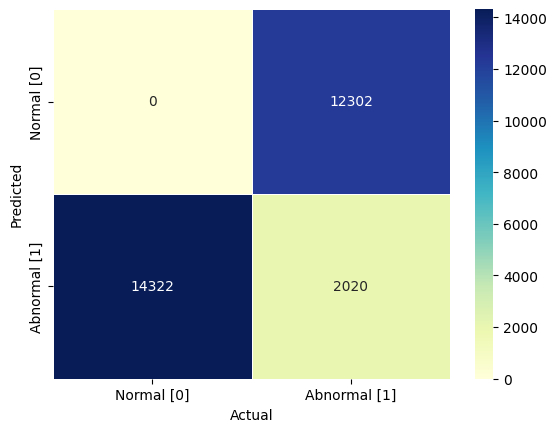

In [58]:
map_labels = True 
model_score = measure_performance(MCD, df_test, test_y, map_labels)
performance_df = pd.DataFrame().append({'model_name':MCD, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

In [59]:
from pyod.models.pca import PCA
PCA = PCA(contamination=0.1)
PCA.fit(X_scaled_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [60]:
anomaly_score_PCA_train = PCA.decision_function(X_scaled_train)
anomaly_score_PCA_train

array([2.68857253e+33, 2.68857253e+33, 2.68536481e+33, ...,
       4.42254418e+33, 4.39627965e+33, 4.32233752e+33])

In [61]:
anomaly_score_PCA_sorted = sorted(anomaly_score_PCA_train)

In [62]:
PCA_test_pred = PCA.predict(X_scaled_test) 

In [63]:
anomaly_score_PCA_test = PCA.decision_function(X_scaled_test)
anomaly_score_PCA_test.shape

(28644,)

In [64]:
error = np.array(anomaly_score_PCA_sorted)     
error = error.reshape(-1,1)

error_test=np.array(anomaly_score_PCA_test)
error_test = error_test.reshape(-1,1)

In [65]:
thresh_PCA = np.percentile(error, 95)

In [66]:
# classifier
df_test = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > thresh_PCA:
            df_test.append('1')
        else:
            df_test.append('0')

In [67]:
novelty_classifier(error_test)

In [68]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset

    df_pred_test = pd.DataFrame(X_test, columns=['Pred'])
    x_pred = df_pred_test['Pred'] 
    
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Normal [0]', 'Abnormal [1]'], 
                yticklabels=['Normal [0]', 'Abnormal [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(X_test, y_true))
    
    model_score = score(X_test, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.99      0.50      0.66     28540

    accuracy                           0.50     28644
   macro avg       0.50      0.25      0.33     28644
weighted avg       0.99      0.50      0.66     28644

f1_score: 33.17%


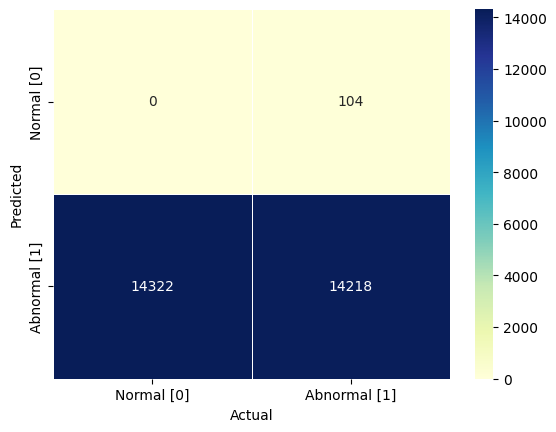

In [69]:
map_labels = True 
model_score = measure_performance(PCA, df_test, test_y, map_labels)
performance_df = pd.DataFrame().append({'model_name':PCA, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

In [195]:
from pyod.models.ocsvm import OCSVM
OCSVM = OCSVM(kernel='rbf', degree=10, gamma='auto', nu=0.5)
OCSVM.fit(X_scaled_train)

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=10, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [ ]:
anomaly_score_OCSVM_train = OCSVM.decision_function(X_scaled_train)
anomaly_score_OCSVM_train

In [ ]:
anomaly_score_OCSVM_sorted = sorted(anomaly_score_OCSVM_train)

In [ ]:
OCSVM_test_pred = OCSVM.predict(X_scaled_test) 

In [ ]:
anomaly_score_OCSVM_test = OCSVM.decision_function(X_scaled_test)
anomaly_score_OCSVM_test.shape

In [ ]:
error = np.array(anomaly_score_OCSVM_sorted)     
error = error.reshape(-1,1)

error_test=np.array(anomaly_score_OCSVM_test)
error_test = error_test.reshape(-1,1)

In [ ]:
thresh_OCSVM = np.percentile(error, 95)

In [ ]:
# classifier
df_test = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > thresh_OCSVM:
            df_test.append('1')
        else:
            df_test.append('0')

In [ ]:
novelty_classifier(error_test)

In [ ]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset

    df_pred_test = pd.DataFrame(X_test, columns=['Pred'])
    x_pred = df_pred_test['Pred'] 
    
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Normal [0]', 'Abnormal [1]'], 
                yticklabels=['Normal [0]', 'Abnormal [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(X_test, y_true))
    
    model_score = score(X_test, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

In [ ]:
map_labels = True 
model_score = measure_performance(OCSVM, df_test, test_y, map_labels)
performance_df = pd.DataFrame().append({'model_name':OCSVM, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

In [81]:
from pyod.models.iforest import IForest
IForest = IForest(n_estimators=10, contamination=0.005, random_state=3, verbose=0, bootstrap=False)
IForest.fit(X_scaled_train)

IForest(behaviour='old', bootstrap=False, contamination=0.005,
    max_features=1.0, max_samples='auto', n_estimators=10, n_jobs=1,
    random_state=3, verbose=0)

In [82]:
anomaly_score_IForest_train = IForest.decision_function(X_scaled_train)
anomaly_score_IForest_train

array([-0.26682634, -0.26682634, -0.28186317, ..., -0.19574654,
       -0.18325443, -0.18254053])

In [83]:
anomaly_score_IForest_sorted = sorted(anomaly_score_IForest_train)

In [84]:
IForest_test_pred = IForest.predict(X_scaled_test) 

In [85]:
anomaly_score_IForest_test = IForest.decision_function(X_scaled_test)
anomaly_score_IForest_test.shape

(28644,)

In [86]:
error = np.array(anomaly_score_IForest_sorted)     
error = error.reshape(-1,1)

error_test=np.array(anomaly_score_IForest_test)
error_test = error_test.reshape(-1,1)

In [87]:
thresh_IForest = np.percentile(error, 95)

In [88]:
# classifier
df_test = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > thresh_IForest:
            df_test.append('1')
        else:
            df_test.append('0')

In [89]:
novelty_classifier(error_test)

In [90]:
def measure_performance(model, X_test, y_true, map_labels):
    # predict on testset

    df_pred_test = pd.DataFrame(X_test, columns=['Pred'])
    x_pred = df_pred_test['Pred'] 
    
    matrix = confusion_matrix(x_pred, y_true)

    sns.heatmap(pd.DataFrame(matrix, columns = ['Actual', 'Predicted']),
                xticklabels=['Normal [0]', 'Abnormal [1]'], 
                yticklabels=['Normal [0]', 'Abnormal [1]'], 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    
    print(classification_report(X_test, y_true))
    
    model_score = score(X_test, y_true,average='macro')
    print(f'f1_score: {np.round(model_score[2]*100, 2)}%')
    
    return model_score

              precision    recall  f1-score   support

           0       0.01      0.02      0.02      9542
           1       0.35      0.26      0.30     19102

    accuracy                           0.18     28644
   macro avg       0.18      0.14      0.16     28644
weighted avg       0.24      0.18      0.20     28644

f1_score: 15.73%


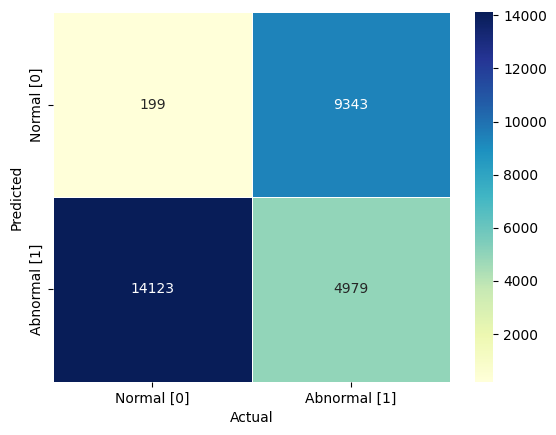

In [91]:
map_labels = True 
model_score = measure_performance(IForest, df_test, test_y, map_labels)
performance_df = pd.DataFrame().append({'model_name':IForest, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)